<a href="https://colab.research.google.com/github/liuchiente/DigitalImageProcessAtNCHU/blob/main/InDoor%26OutDoorL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#掛載Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


 環境初始化

In [ ]:
#載入框架
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import zipfile
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#切換預設目錄
SYS_DIR = "/content/drive/My Drive/Colab Notebooks/InsideOut"
if not os.path.isdir(SYS_DIR):
    os.mkdir(SYS_DIR)
os.chdir(SYS_DIR)

In [ ]:
#下載資料集
!unrar x "/content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor.rar" "/content/drive/My Drive/Colab Notebooks/InsideOut/IO/"
!unrar x "/content/drive/My Drive/Colab Notebooks/InsideOut/IO/indoor.rar" "/content/drive/My Drive/Colab Notebooks/InsideOut/IO/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor.rar

Creating    /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor  OK
Extracting  /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor/1 (1).jpg       0%  OK 
Extracting  /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor/1 (10).jpg       0%  OK 
Extracting  /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor/1 (100).jpg       0%  OK 
Extracting  /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor/1 (101).jpg       1%  OK 
Extracting  /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor/1 (102).jpg       1%  OK 
Extracting  /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor/1 (103).jpg       1%  OK 
Extracting  /content/drive/My Drive/Colab Notebooks/InsideOut/IO/outdoor/1 (104).jpg       1%  2%  OK 
Extracting 

In [ ]:
#設定使用GPU做訓練
device = torch.cuda.is_available()
if not device:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

CUDA is available!


設定基本參數

In [ ]:
# 每次讀多少張圖片
num_workers = 100
# 每次丟多少資料進Model
batch_size = 32
# learning rate
learning_rate = 0.01

In [ ]:
#設定訓練、驗證和測試資料夾路徑
path_of_train="IO/train"
path_of_val="IO/valid"
path_of_test="IO/test"
train =Path(path_of_train)
valid = Path(path_of_val)
test=Path(path_of_test)

In [ ]:
#設定標準化,避免Over fitting
transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])

Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [ ]:
#設定圖片分類
classes = ['indoor','outdoor']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])

In [ ]:
#此處設定資料轉換,會將圖片轉成Tensor
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [ ]:
#設定資料載入
train_data = datasets.ImageFolder(train, transform=train_transforms)
valid_data = datasets.ImageFolder(valid,transform=valid_transforms)
test_data = datasets.ImageFolder(test, transform=test_transforms)


In [ ]:
#檢查資料是否如同設定相同,室內為Label 0,室外為Label 1
print(train_data.class_to_idx)
print(valid_data.class_to_idx)

{'indoor': 0, 'outdoor': 1}
{'indoor': 0, 'outdoor': 1}


In [ ]:
#讀入訓練、驗證、測試資料,把訓練、驗證讀入順序打亂,減少Over fitting機率
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)


In [ ]:
#定義反標準化函式,還有圖片顯示函式,後面做檢查使用
def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) 
  image = image.permute(1,2,0)
  image = torch.clamp(image,0,1)
  return image

#用來把向量轉成圖片顯示
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

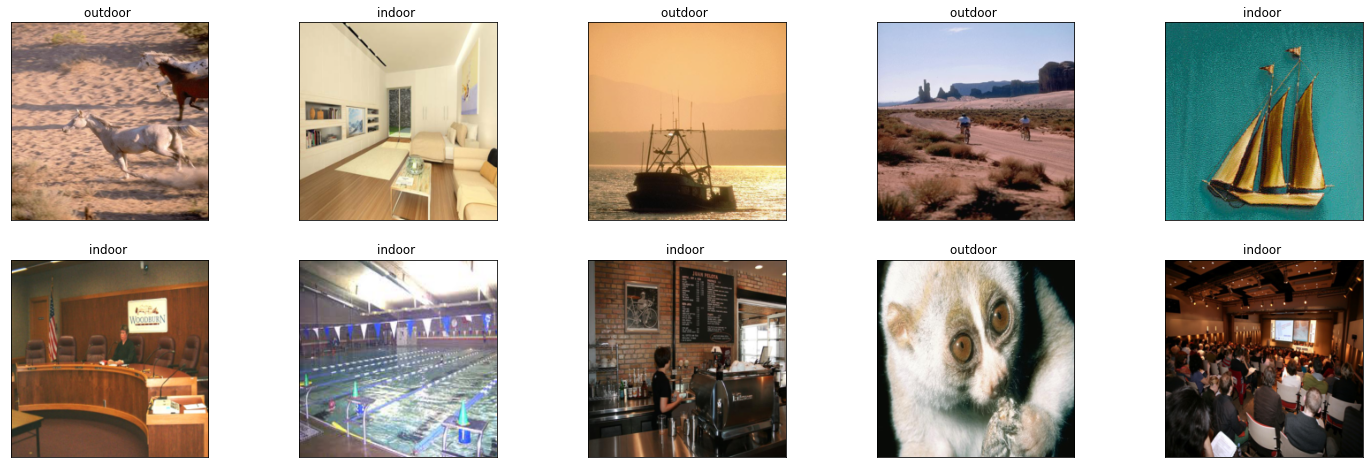

In [ ]:
#測試看看資料集是否如預期,正確標示出室內和室外
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 8))
#秀10張即可
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))


In [ ]:
#定義網路
class CNNM(nn.Module):
    def __init__(self):
        super(CNNM, self).__init__()
        #二維CNN層1, 輸入=(3,224,224)
        #輸出=(16,220,220)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        #激勵,去掉線性關係
        self.relu1 = nn.ReLU() 
        #取最大值,丟掉其他預測
        #輸出=(16,110,110) 
        #(220/2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #二維CNN層 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,106,106)
        #激勵,去掉線性關係
        self.relu2 = nn.ReLU()
        #取最大值,丟掉其他預測
        #輸出=(32,53,53)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #二維CNN層3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,51,51)
        #激勵,去掉線性關係
        self.relu3 = nn.ReLU()
        #取最大值,丟掉其他預測
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,25,25)
        #二維CNN層4
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=0) #output_shape=(8,23,23)
        self.relu4 = nn.ReLU() # activation
        #取最大值,丟掉其他預測
        #輸出=(8,11,11)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        #全連接層,準備輸出預測
        self.fc1 = nn.Linear(8 * 11 * 11, 512)
        #激勵,去掉線性關係
        #全連接層,準備輸出預測
        self.fc2 = nn.Linear(512, 256) 
        #全連接層,準備輸出預測
        self.fc3 = nn.Linear(256, 2) 
        self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        # 第一層
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
         # 第二層
        out = self.cnn2(out)
        out = self.relu2(out) 
        out = self.maxpool2(out)
        # 第三層
        out = self.cnn3(out) 
        out = self.relu3(out)
        out = self.maxpool3(out)
        # 第四層
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)
        out = out.view(out.size(0), -1)
        #FC降維後輸出
        out =  self.fc3(self.fc2(self.fc1(out)))
        out = self.output(out)

        return out

In [ ]:
#查看網路定義狀況
model = CNNM()
from torchsummary import summary
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Conv2d-7           [-1, 16, 51, 51]           4,624
              ReLU-8           [-1, 16, 51, 51]               0
         MaxPool2d-9           [-1, 16, 25, 25]               0
           Conv2d-10            [-1, 8, 23, 23]           1,160
             ReLU-11            [-1, 8, 23, 23]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Linear-13                  [-1, 512]         496,128
           Linear-14                  [

In [ ]:
#定義Loss計算和優化
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
from tqdm import tqdm_notebook as tqdm

epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



	Training Loss: 0.562318
epoch: 2



	Training Loss: 0.549321
epoch: 3



	Training Loss: 0.518494
epoch: 4



	Training Loss: 0.519350
epoch: 5



	Training Loss: 0.499732
epoch: 6



	Training Loss: 0.486512
epoch: 7



	Training Loss: 0.495218
epoch: 8



	Training Loss: 0.493996
epoch: 9



	Training Loss: 0.498592
epoch: 10



	Training Loss: 0.485404
epoch: 11



	Training Loss: 0.462167
epoch: 12



	Training Loss: 0.457854
epoch: 13



	Training Loss: 0.459650
epoch: 14



	Training Loss: 0.464211
epoch: 15



	Training Loss: 0.474243


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



	Validation Loss: 0.481543
Validation loss decreased (inf --> 0.481543).  Saving model ...



	Validation Loss: 0.491174



	Validation Loss: 0.491367



	Validation Loss: 0.491370



	Validation Loss: 0.491371



	Validation Loss: 0.491370



	Validation Loss: 0.491371



	Validation Loss: 0.491371



	Validation Loss: 0.491371



	Validation Loss: 0.491371



	Validation Loss: 0.491371



	Validation Loss: 0.491370



	Validation Loss: 0.491371



	Validation Loss: 0.491370



	Validation Loss: 0.491370


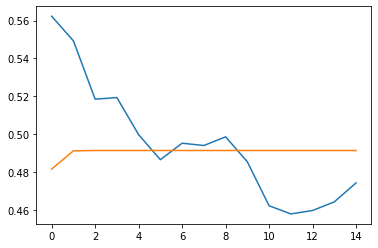

In [ ]:
#訓練次數
epochs = 15
#假定一開始的驗證loss是無限大,後面可以看出變化
valid_loss_min = np.Inf
train_losses=[]
valid_losses=[]
#訓練
for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    print('epoch: {}'.format(epoch))
    model.train()
    for data, target in tqdm(train_loader):
        #用GPU
        if device:
            data, target = data.cuda(), target.cuda()
        #優化器優化之前須將梯度歸零
        optimizer.zero_grad()
        #訓練
        output = model(data)
        #loss計算
        loss = criterion(output, target)
        #反向傳遞
        loss.backward()
        #通過梯度做參數更新(更新權重)
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    #計算平均Loss機率
    train_loss = train_loss/len(train_loader.dataset)
    train_losses.append(train_loss)
    # 印出訓練Loss率
    print('\tTraining Loss: {:.6f}'.format(train_loss))
plt.plot(range(epochs),train_losses)
#評估效果
for epoch in range(1, epochs+1):       
    model.eval()
    for data, target in tqdm(valid_loader):
        #用GPU
        if device:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        #loss計算
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    #計算平均Loss機率
    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    # 印出訓練Loss率
    print('\tValidation Loss: {:.6f}'.format(valid_loss)) 
    #如果Loss機率有遞減的話再儲存
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'InOutModel.pth')
        valid_loss_min = valid_loss
plt.plot(range(epochs),valid_losses) 

In [ ]:
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        fig = plt.figure(figsize=(25, 8))
        #秀10張即可
        for idx in np.arange(10):
            ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
            imshow(data[idx])
            ax.set_title("{} ".format(classes[target[idx]]))


        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        for idx in np.arange(10):
          print(output[idx])
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

tensor([0.9939, 0.0061], device='cuda:0', grad_fn=<SelectBackward>)
tensor([1.0000e+00, 2.5225e-11], device='cuda:0', grad_fn=<SelectBackward>)
tensor([0.7606, 0.2394], device='cuda:0', grad_fn=<SelectBackward>)
tensor([1.0000e+00, 5.7319e-09], device='cuda:0', grad_fn=<SelectBackward>)
tensor([9.9984e-01, 1.6223e-04], device='cuda:0', grad_fn=<SelectBackward>)
tensor([0.0158, 0.9842], device='cuda:0', grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.7063e-10], device='cuda:0', grad_fn=<SelectBackward>)
tensor([3.4816e-08, 1.0000e+00], device='cuda:0', grad_fn=<SelectBackward>)
tensor([1.3930e-09, 1.0000e+00], device='cuda:0', grad_fn=<SelectBackward>)
tensor([0.0012, 0.9988], device='cuda:0', grad_fn=<SelectBackward>)
Test Loss: 0.393129
Test Accuracy: 90% ( 9/10)


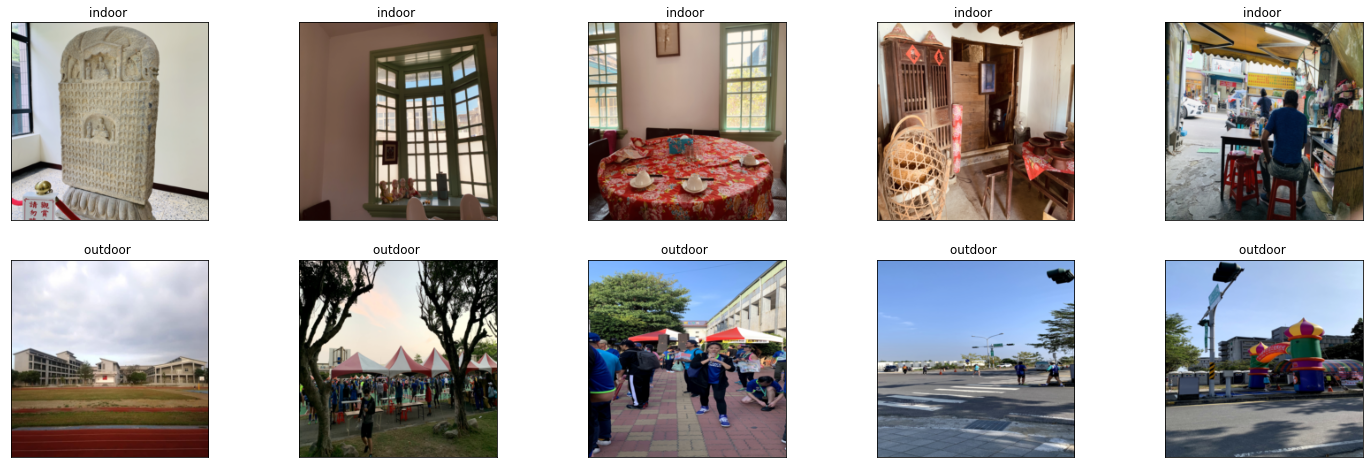

In [ ]:
use_cuda = torch.cuda.is_available()
model.cuda()
test(test_loader, model, criterion, use_cuda)